# Stochastic differential equation

## Introduction

The aim of a stochastic differential equation is to add a description of the uncertainty to a differential equation. Assume we have a simple model for an oscillator:

- $dx/dt = u$
- $du/dt = -c^2 x$
- $x(0)=x_o$ and $u(0)=0$



In [1]:
# import some useful packages first
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn #random number generator for normal or gaussian distributed variables.
from math import * #basic math functions

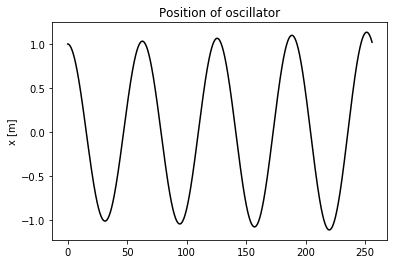

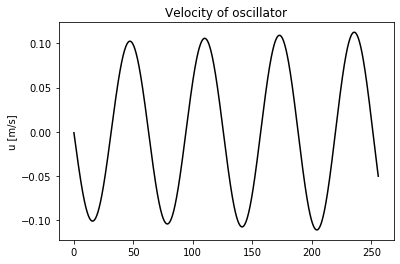

In [2]:
L=256
dt=0.1
c=0.1
t_all = np.arange(dt,L,dt)
n=len(t_all)
x=np.array([[1],[0]])
x_all=np.zeros((2,n))
A=np.array([[1.0,dt],[-c**2*dt, 1.0]]) #discretized oscillator with Euler-forward

i=0
for t in t_all:
    x=A @ x #matrix multiplication
    x_all[:,i]=x[:,0]
    i=i+1
    
plt.plot(t_all,x_all[0,:],'k-')
plt.title("Position of oscillator")
plt.ylabel('x [m]')
plt.show()

plt.plot(t_all,x_all[1,:],'k-')
plt.title("Velocity of oscillator")
plt.ylabel('u [m/s]')
plt.show()


## Uncertainty

A differential equation with proper initial conditions (satisfying some regularity constraints) will give one unique solution. This is a convenient property, but does not reflect the uncertainty attached to the model. The parameter can be uncertain, or the initial condition. It is also possible that the equations themselves are uncertain. The latter can be modelled for exmple as an additive to the equation. For the oscillator this could look like:

- $dx/dt = u$
- $du/dt = -c^2 x + r(t)$
- $x(0)=x_o$ and $u(0)=0$

where $r(t)$ describes the uncertainty of the momentum equation (2nd). For a particular choice of for $r(t)$, this becomes again a system of differential equations with a unique solution. However, it is unlikely that we would know perfectly where and how our equations are wrong. In that case we would indirectly still have the exact equations for our system. A more likely scenario is that we only know some characteristics of $r(t)$ but not its values. For example, one could assume that $r(t)$ is Gaussian with $E r(t)=0$, $E r(t)^2=\sigma_r^2$ and $E r(t)r(s)=\sigma_r^2 \rho(r-s)$ with $\rho(v)=exp(v^2/T^2/2)$. Together, these describe the system in a stochastic sense. We can not say what the value will be exactly, but we can compute its probabilities. Thus for our oscillator with uncertainty description we have:

- $dx/dt = u$
- $du/dt = -c^2 x + r(t)$
- $x(0)=x_o$ and $u(0)=0$
- $r(t)$ Gaussian, $E r(t)=0$, $E r(t)r(s)=\sigma_r^2 exp((t-s)^2/T^2/2)$

Note that here there are no mathematical difficulties because $r(t)$ is smooth enough to be integrated with normal Riemann integration. Let's show this in action first.

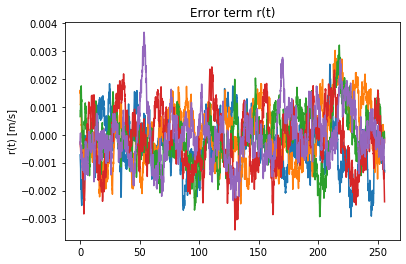

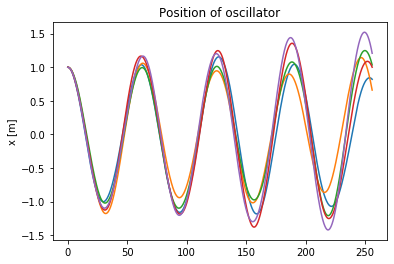

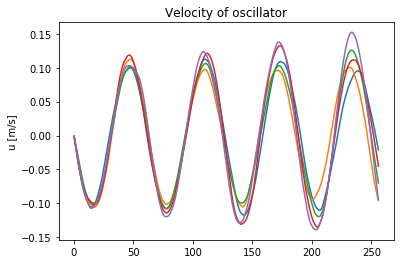

In [136]:
from scipy.linalg import sqrtm
L=256
s=5 #number of samples
dt=0.1
c=0.1
sigma_r=0.001
T=5.0
t_all = np.arange(dt,L,dt)
n=len(t_all)

# create random samples for r(t) using its covariance
t2=np.ones((n,1)) @ t_all.reshape(1,n)
c_r = sigma_r**2 * np.exp((-1.0/T) * np.abs(t2-t2.transpose()))
c_r_sqrt = sqrtm(c_r)
r=c_r_sqrt @ np.random.randn(n,s)

#integrate the system for
x=np.array([[1],[0]]) @ np.ones((1,s))
x_all=np.zeros((2,s,n))
A=np.array([[1.0,dt],[-c**2*dt, 1.0]]) #discretized oscillator with Euler-forward

i=0
for t in t_all:
    x=A @ x #matrix multiplication
    x[1,:]=x[1,:] + dt*r[i] #add error also Euler-forward
    x_all[:,:,i]=x[:,:]
    i=i+1

plt.plot(t_all,r,'-')
plt.title("Error term r(t)")
plt.ylabel('r(t) [m/s]')
plt.show()
    
plt.plot(t_all,x_all[0,:,:].transpose(),'-')
plt.title("Position of oscillator")
plt.ylabel('x [m]')
plt.show()

plt.plot(t_all,x_all[1,:,:].transpose(),'-')
plt.title("Velocity of oscillator")
plt.ylabel('u [m/s]')
plt.show()

The previous example clearly shows how the uncertainty in the position and velocity grow over time. In a real application one would need to tune the parameters of $r(t)$ with measurements of the system. If we neglect errors in the measurements for a while, then the measurements should be within the range of the samples, but also not closely lumped together within the range of the samples. In an ideal stochastic model, reality should be indistinguishable from a sample.

Allthough this example and the approach with time-correlated errors is working, there are several issues: 
- First, the computer time needed for creating samples grows quickly ($O(n^3)$) with the length of the series $n$. There are faster, more complicated, ways to generate correlated samples, but this will remain a relatively expensive part of the computation.
- Second, it is not trivial how to continue a simulation. If we want to have a longer simulation for a normal differential equation, the we can continue the simulation from the previous en point. All we have to do is remenber the dynamic variables, known in systems theory as the state. Here $x$ and $u$.
- Estimation methods such as the Kalman filter, will not work because they need to remember and condition upon all known times sofar.

For discrete-time systems, the situation is much simpler when the noise added is white in time, i.e. not correlated in time. It is both simple to continue at a restart and fast to generate the noise. It would be nice if we could use the model:

- $dx/dt = u$
- $du/dt = -c^2 x + r(t)$
- $x(0)=x_o$ and $u(0)=0$
- $r(t)$ Gaussian, $E r(t)=0$, E r(t)r(s)=\sigma_r^2 \delta(t-s)$

Thus with $r(t)$ as white noise, but in the first notebook it became clear that there are problems this model. It is possible to create a stchastic model, but for that we will have to find a different intepretation of the differential equations (Ito).  

## Stochastic differential equations

$dx = f(x) dt + g(x) dw$

Ito integral

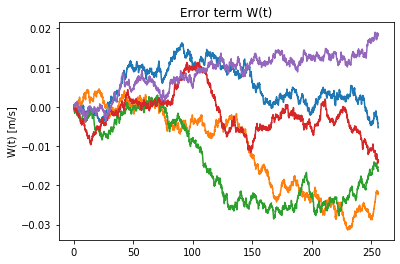

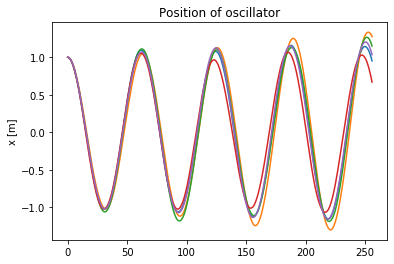

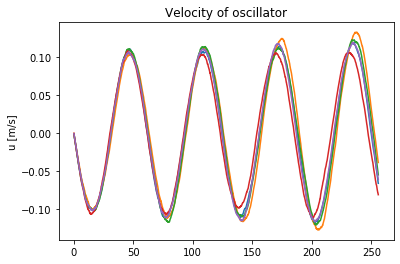

In [144]:
from scipy.linalg import sqrtm
L=256
s=5 #number of samples
dt=0.1
c=0.1
s_w=0.05 #this is an inensity scaling, the standard deviation will grow over time
t_all = np.arange(dt,L,dt)
n=len(t_all)

# create random samples for W(t) using independent increments
N_i = sqrt(dt) * randn(n+1,s) 
W_i = sigma_w * np.cumsum(N_i,axis=0) 

#integrate the system for
x=np.array([[1],[0]]) @ np.ones((1,s))
x_all=np.zeros((2,s,n))
A=np.array([[1.0,dt],[-c**2*dt, 1.0]]) #discretized oscillator with Euler-forward

i=0
for t in t_all:
    x=A @ x #matrix multiplication
    x[1,:]=x[1,:] + (W_i[i+1,:]-W_i[i,:]) #add error as in random-walk
    x_all[:,:,i]=x[:,:]
    i=i+1

plt.plot(t_all,W_i[:-1,:],'-')
plt.title("Error term W(t)")
plt.ylabel('W(t) [m/s]')
plt.show()
    
plt.plot(t_all,x_all[0,:,:].transpose(),'-')
plt.title("Position of oscillator")
plt.ylabel('x [m]')
plt.show()

plt.plot(t_all,x_all[1,:,:].transpose(),'-')
plt.title("Velocity of oscillator")
plt.ylabel('u [m/s]')
plt.show()